In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
import itertools



import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv(r'C:\Users\user\text mining\HR_comma_sep.csv')

In [3]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Exploratory Data Analysis

In [26]:
hr_left = pd.DataFrame(data.left.value_counts()).reset_index()
hr_left.columns = ['left','count']


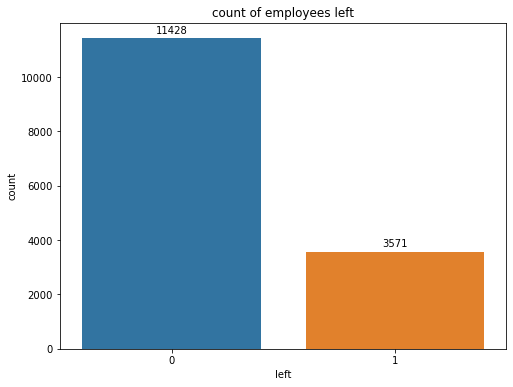

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.barplot(x='left',y='count',data=hr_left)
ax.bar_label(ax.containers[0], padding=3)
plt.title('count of employees left')
plt.show()


<AxesSubplot:ylabel='left'>

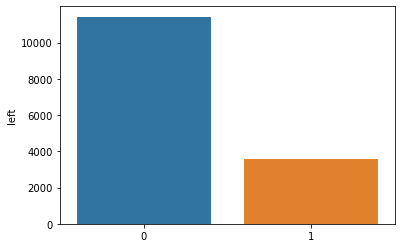

In [7]:
sns.barplot(data=hr_left,x=hr_left.index,y=hr_left.left)

In [27]:
# percent of churn by salary bucket
salary_count = data[['salary','left']].groupby(['salary','left']).size()
salary_count.columns = ['salary','left','count']

In [39]:
salary_percent = salary_count.groupby(level=[0]).apply(lambda x:x/x.sum()).reset_index()
salary_percent.columns = ['salary','left','percent']
salary_percent.sort_values(by='percent',ascending=False)

,salary,left,percent
0,high,0,0.933711
4,medium,0,0.795687
2,low,0,0.703116
3,low,1,0.296884
5,medium,1,0.204313
1,high,1,0.066289


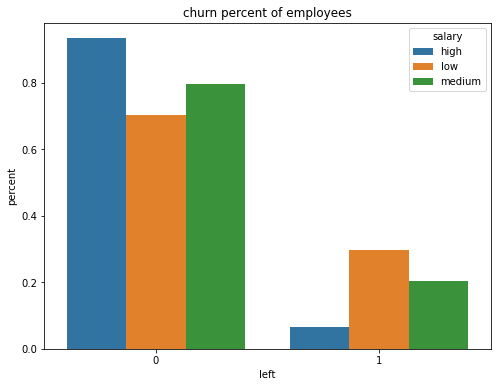

In [38]:
fig, axes = plt.subplots(figsize=(8, 6))
axes = sns.barplot(x='left',y='percent',hue='salary',data=salary_percent)

plt.title('churn percent of employees')
plt.show()


In [11]:
workaccident_churn = data[['Work_accident','left']].groupby(['Work_accident','left']).size()
workaccident_churn = workaccident_churn.groupby(level=[0]).apply(lambda x:x/x.sum()).reset_index()
workaccident_churn.columns = ['work_accident','left','percent']
workaccident_churn

,work_accident,left,percent
0,0,0,0.734840
1,0,1,0.265160
2,1,0,0.922084
3,1,1,0.077916


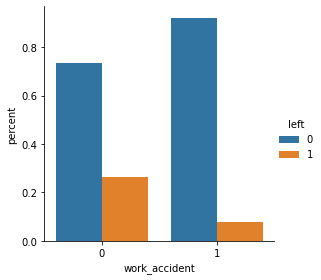

In [12]:
sns.factorplot(x='work_accident',y='percent',data=workaccident_churn,size=4,kind='bar',hue='left')

In [41]:
data.groupby('left')[['satisfaction_level']].sum()

,satisfaction_level
left,
0,7620.30
1,1571.59


<AxesSubplot:xlabel='satisfaction_level', ylabel='Density'>

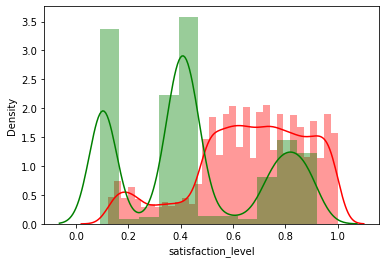

In [15]:
sns.distplot(data[data.left==0]['satisfaction_level'],color='r')
sns.distplot(data[data.left==1]['satisfaction_level'],color='g')

In [16]:
data.groupby('left')[['last_evaluation']].sum()

,last_evaluation
left,
0,8176.43
1,2564.38


<AxesSubplot:xlabel='last_evaluation', ylabel='Density'>

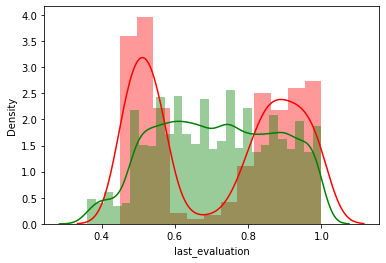

In [17]:
sns.distplot(data[data.left==1]['last_evaluation'],color='r')
sns.distplot(data[data.left==0]['last_evaluation'],color='g')

In [18]:
time_spent =  data[['time_spend_company','left']].groupby(['time_spend_company','left']).size()
time_spent_percent = time_spent.groupby(level=[0]).apply(lambda x:x/x.sum()).reset_index()
time_spent_percent.columns = ['time_spend_company','left','percent']

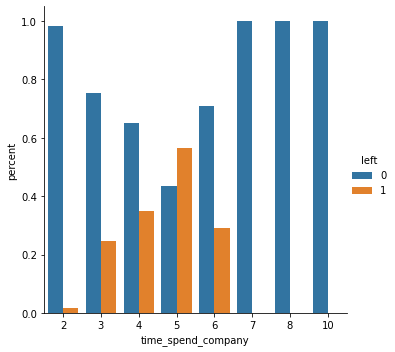

In [19]:
sns.factorplot(data=time_spent_percent,x='time_spend_company',y='percent',hue='left',kind='bar')

In [20]:
department = data[['department','left']].groupby(['department','left']).size()
department_percent = department.groupby(level=[0]).apply(lambda x:x/x.sum()).reset_index()
department_percent.columns = ['department','left','percent']
department_percent

,department,left,percent
0,IT,0,0.777506
1,IT,1,0.222494
2,RandD,0,0.846252
3,RandD,1,0.153748
4,accounting,0,0.734029
5,accounting,1,0.265971
6,hr,0,0.709066
7,hr,1,0.290934
8,management,0,0.855556
9,management,1,0.144444


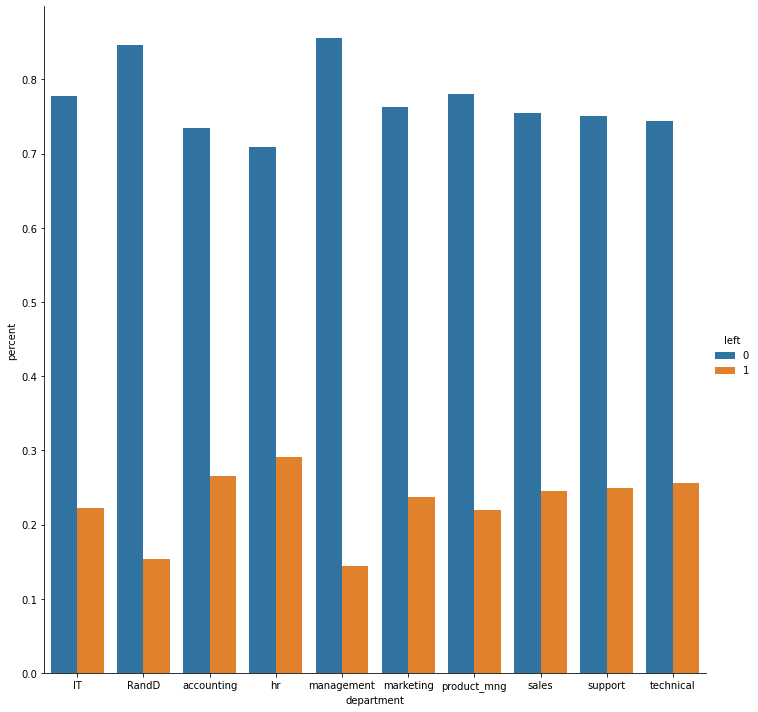

In [21]:
sns.factorplot(data=department_percent,x='department',y='percent',hue='left',kind='bar',size=10)

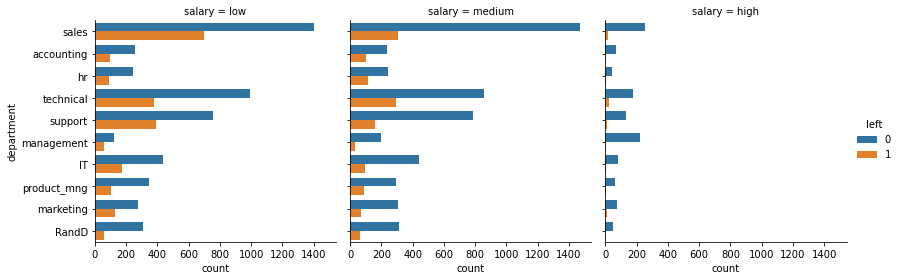

In [22]:
sns.factorplot(data=data,col='salary',y='department',hue='left',kind='count',size=4)

### Analysis :
    1. Out of total employees, about 3571 employees left the company.
    
    2. Large number of people leaving the comapny is because of low salary.
    
    3. Large number of people having low satisfaction leaving the company and mostly people with satisfaction less than 0.5.
       So,the comapny need to understand this and deal with these employees with different strategy.
        
    4. People with less experience are not leaving  the comapny but as they growing they start leaving the company and it is             highest with 5 years. The reason might be low salary or low satisfaction level.

    5. The percent of people leaving the company is evenly distributed across all departments, but the highest is in HR                department itself.
    

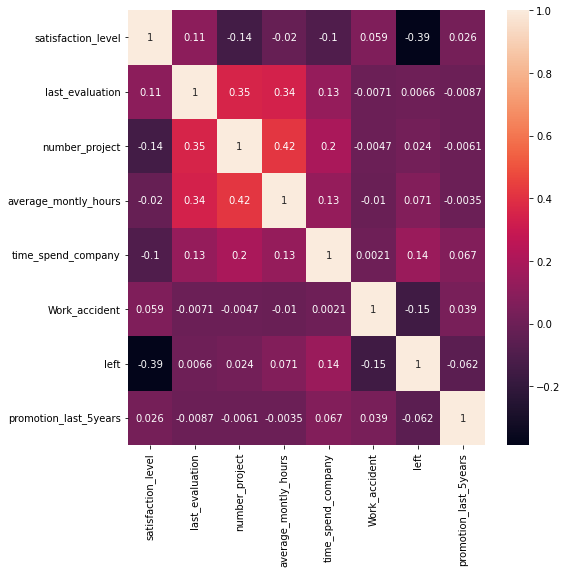

In [48]:
plt.figure(figsize=(8,8))
sns.heatmap(data.corr(),annot=True)
plt.show()

### Encoding Categorical Variable

In [23]:
cat_var = data.select_dtypes(exclude='number')

In [24]:
cat_var

,department,salary
0,sales,low
1,sales,medium
2,sales,medium
3,sales,low
4,sales,low
...,...,...
14994,support,low
14995,support,low
14996,support,low
14997,support,low


In [25]:
data = pd.get_dummies(data=data,columns=['Work_accident','promotion_last_5years', 'department', 'salary'],drop_first=True)

### Splitting data into train and test

In [26]:
x=data[data.columns.difference(['left'])]
y= data['left']

In [27]:
y

0        1
1        1
2        1
3        1
4        1
        ..
14994    1
14995    1
14996    1
14997    1
14998    1
Name: left, Length: 14999, dtype: int64

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
train_x,test_x,train_y,test_y= train_test_split(x,y,test_size=0.3,random_state=123)

In [30]:
print('train_x shape:',train_x.shape)
print('train_y shape:',train_y.shape)
print('test_x shape:',test_x.shape)
print('test_y shape:',test_y.shape)

train_x shape: (10499, 18)
train_y shape: (10499,)
test_x shape: (4500, 18)
test_y shape: (4500,)


### Model Building

In [31]:
# logistic regression - Baseline model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [32]:
logreg = LogisticRegression()

In [33]:
log_model = logreg.fit(train_x,train_y)

In [34]:
train_pred = log_model.predict(train_x)
test_pred = log_model.predict(test_x)

In [35]:
print(metrics.classification_report(train_y,train_pred))
print(metrics.classification_report(test_y,test_pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      7999
           1       0.64      0.41      0.50      2500

    accuracy                           0.80     10499
   macro avg       0.73      0.67      0.69     10499
weighted avg       0.79      0.80      0.79     10499

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      3429
           1       0.63      0.38      0.48      1071

    accuracy                           0.80      4500
   macro avg       0.73      0.66      0.68      4500
weighted avg       0.78      0.80      0.78      4500



In [36]:
#feature engineering
np.abs(data.corrwith(data.left)).sort_values(ascending=False)

left                       1.000000
satisfaction_level         0.388375
Work_accident_1            0.154622
time_spend_company         0.144822
salary_low                 0.134722
average_montly_hours       0.071287
salary_medium              0.068833
promotion_last_5years_1    0.061788
department_RandD           0.046596
department_management      0.046035
department_hr              0.028249
number_project             0.023787
department_technical       0.020076
department_accounting      0.015201
department_product_mng     0.011029
department_support         0.010700
department_sales           0.009923
last_evaluation            0.006567
department_marketing       0.000859
dtype: float64

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [38]:
grid = GridSearchCV(estimator=DecisionTreeClassifier(),param_grid={'max_depth':[3,4,5,6,7,8,9],'max_features':[2,4,6,8,10,12,14,16,18],
                                                           'max_leaf_nodes':[10,20,30,40,50]},scoring='roc_auc',verbose=True)

In [39]:
grid = grid.fit(train_x,train_y)

Fitting 5 folds for each of 315 candidates, totalling 1575 fits


In [41]:
grid.best_params_

{'max_depth': 7, 'max_features': 18, 'max_leaf_nodes': 50}

In [42]:
model_tree = DecisionTreeClassifier(max_depth=7,max_features=18,max_leaf_nodes=50).fit(train_x,train_y)

In [43]:
print(metrics.classification_report(train_y,model_tree.predict(train_x)))
print(metrics.classification_report(test_y,model_tree.predict(test_x)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7999
           1       0.99      0.94      0.96      2500

    accuracy                           0.98     10499
   macro avg       0.98      0.97      0.97     10499
weighted avg       0.98      0.98      0.98     10499

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3429
           1       0.98      0.92      0.95      1071

    accuracy                           0.98      4500
   macro avg       0.98      0.96      0.97      4500
weighted avg       0.98      0.98      0.98      4500



In [40]:
import itertools

In [46]:
feature_map = [(i,v) for i,v in itertools.zip_longest(model_tree.feature_importances_,train_x.columns)]

In [53]:
feature = pd.DataFrame(feature_map,columns=['importance','feature']).sort_values(by='importance',ascending=False)

In [54]:
feature

,importance,feature
16,0.520060,satisfaction_level
17,0.159931,time_spend_company
11,0.143034,last_evaluation
12,0.108307,number_project
1,0.065669,average_montly_hours
9,0.001232,department_support
14,0.000998,salary_low
3,0.000675,department_accounting
10,0.000094,department_technical
6,0.000000,department_marketing


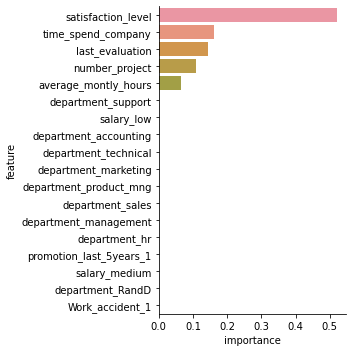

In [55]:
sns.factorplot(x='importance',y='feature',data=feature,kind='bar')

In [56]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

In [ ]:
RandomForestClassifier

In [62]:
param_grid = {'n_estimators':[3,6,9,12],'max_depth':[3,4,5,6,7,8,9],'max_features':[2,4,6,8,10,12,14,16,18],
             'max_leaf_nodes':[2,4,6,8,10]}
grid_RF = GridSearchCV(estimator=RandomForestClassifier(),param_grid=param_grid,cv=5,scoring='roc_auc',verbose=True).fit(train_x,train_y)

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


In [63]:
grid_RF.best_params_

{'max_depth': 5, 'max_features': 12, 'max_leaf_nodes': 10, 'n_estimators': 12}

In [64]:
model_RF = RandomForestClassifier(n_estimators=12,max_depth=5,max_features=12,max_leaf_nodes=10).fit(train_x,train_y)

In [65]:
print(metrics.classification_report(train_y,model_RF.predict(train_x)))
print(metrics.classification_report(test_y,model_RF.predict(test_x)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7999
           1       0.96      0.92      0.94      2500

    accuracy                           0.97     10499
   macro avg       0.97      0.95      0.96     10499
weighted avg       0.97      0.97      0.97     10499

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3429
           1       0.94      0.91      0.92      1071

    accuracy                           0.96      4500
   macro avg       0.96      0.95      0.95      4500
weighted avg       0.96      0.96      0.96      4500



In [67]:
feature_RF = [(i,v) for i,v in itertools.zip_longest(model_RF.feature_importances_,train_x.columns)]

In [71]:
feature_rf = pd.DataFrame(feature_RF,columns=['importance','feature']).sort_values(by='importance',ascending=False)

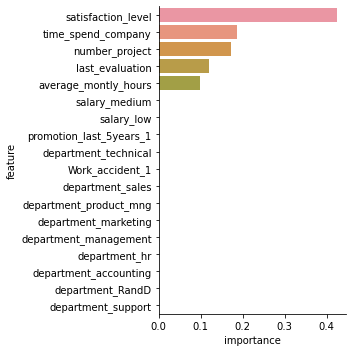

In [73]:
sns.factorplot(y='feature',x='importance',data=feature_rf,kind='bar')

In [76]:
from xgboost import XGBClassifier

In [79]:
model_XG = XGBClassifier(learning_rate=0.01,
                               n_estimators=1000,
                               max_depth=5,
                               min_child_weight=1,
                               gamma=1,
                               subsample=0.8,
                               colsample_bytree=0.8,
                               n_jobs=-1,
                               reg_alpa=1,
                               scale_pos_weight=1,
                               random_state=42,
                               verbose=1).fit(train_x,train_y)

[13:53:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "reg_alpa", "verbose" } are not used.



In [80]:
print(metrics.classification_report(train_y,model_XG.predict(train_x)))
print(metrics.classification_report(test_y,model_XG.predict(test_x)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7999
           1       0.99      0.94      0.96      2500

    accuracy                           0.98     10499
   macro avg       0.98      0.97      0.98     10499
weighted avg       0.98      0.98      0.98     10499

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3429
           1       0.98      0.92      0.95      1071

    accuracy                           0.98      4500
   macro avg       0.98      0.96      0.97      4500
weighted avg       0.98      0.98      0.98      4500



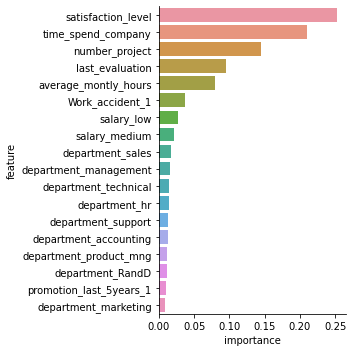

In [82]:
feature_XG = [(i,v) for i,v in itertools.zip_longest(model_XG.feature_importances_,train_x.columns)]
feature_xg = pd.DataFrame(feature_XG,columns=['importance','feature']).sort_values(by='importance',ascending=False)
sns.factorplot(y='feature',x='importance',data=feature_xg,kind='bar')

In [83]:
feature_xg

,importance,feature
16,0.252272,satisfaction_level
17,0.209802,time_spend_company
12,0.145482,number_project
11,0.095381,last_evaluation
1,0.079868,average_montly_hours
0,0.037431,Work_accident_1
14,0.027596,salary_low
15,0.021287,salary_medium
8,0.016744,department_sales
5,0.016042,department_management
